# **Trabalho Final**: Deep Learning MO434/MC934
Universidade Estadual de Campinas (UNICAMP), Instituto de Computação (IC)

Profa. Sandra Avila, 2020s2





In [ ]:
# RA & Name
print('265673: ' + 'Gabriel Luciano Gomes')
print('265146: ' + 'Gabriel Oliveira Campos')
print('265674: ' + 'Paulo Júnio Reis Rodrigues')

265673: Gabriel Luciano Gomes
265146: Gabriel Oliveira Campos
265674: Paulo Júnio Reis Rodrigues


## Objetivo

O objetivo deste trabalho é identificar, por meio de análise de raio x pulmonar, a presença de pneumonia nos pacientes. Junto a isso, caso positivo, identificar qual o motivo desta doença, seja ela causada por vírus ou por bactéria. Ainda assim, caso possível, detectar as subcategorias da enfermidade, sendo elas, COVID-19, SARS (Síndrome respiratória aguda grave) ou pela bactéria Streptococcus. Com isso, a finalidade do projeto é interessante, pois além de facilitar a identificação e classificação da patologia, auxiliará os agentes de saúde nos passos a serem adotados para recuperação da pessoa infectada. 

## Dataset

Para este projeto, será utilizado a base [CoronaHack -Chest X-Ray-Dataset](https://www.kaggle.com/praveengovi/coronahack-chest-xraydataset), dos autores *Joseph Paul Cohen, Paul Morrison and Lan Dao,* encontrada na plataforma **Kaggle**. A base é constituída por 5.910 imagens (JPEG) radiográficas da parte torácica dos pacientes. O conteúdo está categorizadas em dois grupos, pulmões saudáveis (1576 imagens) e pulmões com presença de pneumonia (4334 imagens). Este grupo está subdividido em outros grupos menores, sendo eles: 

| Causa  | Imagens  |  
|---|---|
| Fumo por estresse  | 2  |
| Vírus (sem categoria)  | 1493   |
| Vírus (COVID-19)  | 58  |
| Vírus (SARS)  | 4  |
| Bactéria (sem categoria)  | 2772  |
| Bactéria (Streptococcus)  | 5  |

A base está divida em duas grandes partes. A primeira delas, é a seção de treinamento, onde se encontra 5.286 imagens, partilhadas em dois grupos: 1.342 figuras de pulmões sem nenhuma pneumonia e 3.944 figuras de pulmões com pneumonia. Já a segunda parte é utilizada para a fase de testes, que é constituída por 624 imagens.

Todas as imagens foram retiradas de fontes públicas, bem como coleta indireta de hospitais e médicos.


## Carregamento dos Dados

O .zip contendo o dataset está hospedado no Kaggle. O código abaixo faz o download, e extrai o zip. Note que você precisará fazer o uplaod de um arquivo json, que pode ser obtido no próprio Kaggle na seção de API, presente nas configurações da conta. Caso haja alguma falha ou erro no processo, reinicie o notebook, e tente novamente.

Depois desse processo, teremos no diretório os seguintes arquivos:
* files
  - Coronahack-Chest-XRay-Dataset
    - Coronahack-Chest-XRay-Dataset/train: 5309 imagens.
    - Coronahack-Chest-XRay-Dataset/test: 624 imagens.
  - Chest_xray_Corona_Metadata.csv
  - Chest_xray_Corona_dataset_Summary.csv

In [ ]:
!pip install kaggle

In [ ]:
# Imports
from google.colab import files
import zipfile
from keras.preprocessing.image import ImageDataGenerator
import pandas as pd
import numpy as np
import tensorflow as tf
from matplotlib import pyplot

In [ ]:
files.upload()

# Since Kaggle API expects the json file to be in ~./kaggle folder, the following code does it.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
# Downloading and unzipping the data
!kaggle datasets download -d praveengovi/coronahack-chest-xraydataset
zip_ref = zipfile.ZipFile("coronahack-chest-xraydataset.zip", "r")
zip_ref.extractall("files")
zip_ref.close()

100% 1.18G/1.19G [00:13<00:00, 95.2MB/s]
100% 1.19G/1.19G [00:13<00:00, 95.6MB/s]


In [ ]:
from sklearn.utils import shuffle
df = pd.read_csv('/content/files/Chest_xray_Corona_Metadata.csv')
df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


È possível indentificar os seguintes campos no conjunto de dados:

 - **X_ray_image_name:** nome da imagem
 - **Label:** identificação de presença ou não de Pnemonia ('Normal' ou 'Pnemonia')
 - **Dataset_type:** informação de qual conjunto a imagem pertence ('TRAIN' ou 'TEST')
 - **Label_2_Virus_category:** informação do vírus detectado ('NaN', 'Streptococcus', 'COVID-19', 'ARDS' ou 'SARS')
 - **Label_1_Virus_category:** informação de como a doença foi contraída ('NaN', 'Virus', 'bacteria', 'Stress-Smoking')

In [ ]:
# Identifying the train and test dataset within database
trainVal = df.loc[df.Dataset_type == 'TRAIN']
test = df.loc[df.Dataset_type == 'TEST']

# Shuffle and split test database into 80% train and 20% validation
nData = trainVal.shape[0]
nTrain = int(nData * 0.8)
randomIdx = np.random.permutation(np.arange(nData))
trainIdx = randomIdx[:nTrain]
valIdx = randomIdx[nTrain:]

val = trainVal.copy().drop(trainIdx)
train = trainVal.copy().drop(valIdx)


print("Conjunto de Treino -> ", train.shape)
print("Conjunto de Validação -> ", val.shape)
print("Conjunto de Teste -> ", test.shape)

Conjunto de Treino ->  (4228, 6)
Conjunto de Validação ->  (1058, 6)
Conjunto de Teste ->  (624, 6)


### Embaralhando a base de treino e validação

In [ ]:
train = shuffle(train).reset_index(drop=True)
val = shuffle(val).reset_index(drop=True)
train.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,847,NORMAL2-IM-0753-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1778,person1193_virus_2034.jpeg,Pnemonia,TRAIN,NaN,Virus
2,3590,person337_bacteria_1563.jpeg,Pnemonia,TRAIN,NaN,bacteria
3,920,NORMAL2-IM-0851-0001.jpeg,Normal,TRAIN,NaN,NaN
4,5176,person912_bacteria_2837.jpeg,Pnemonia,TRAIN,NaN,bacteria


## Remoção de campos nulos

In [ ]:
# Verifying if there are null fields
df.isnull().sum()

Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64

In [ ]:
# As 'NaN' is considered a null value, we're going to replace it with 'unknown'
# since it represents how the injury was contract
df.fillna('unknown', inplace=True)

# verifying dataset after the replacement
print(df['Label_1_Virus_category'].value_counts())
print('-'*42)
print(df['Label_2_Virus_category'].value_counts())

bacteria          2777
unknown           1576
Virus             1555
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64
------------------------------------------
unknown          5841
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: int64


## Data Generator


In [ ]:
train_datagen = ImageDataGenerator(shear_range=0.2,
                                    zoom_range=0.2,
                                    rescale=1./255,
                                    horizontal_flip=True)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_path = '/content/files/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
test_path = '/content/files/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

train_gen = train_datagen.flow_from_dataframe(dataframe=train,
                                            directory=train_path,
                                            x_col="X_ray_image_name",
                                            y_col="Label",
                                            target_size=(224,224),
                                            batch_size=64,
                                            class_mode='binary',
                                            shuffle=True,
                                            seed=21100109
                                            )
val_gen = val_datagen.flow_from_dataframe(dataframe=val,
                                            directory=train_path,
                                            x_col="X_ray_image_name",
                                            y_col="Label",
                                            target_size=(224,224),
                                            batch_size=64,
                                            class_mode='binary',
                                            shuffle=True,
                                            seed=21100109
                                            )

Found 4228 validated image filenames belonging to 2 classes.
Found 1058 validated image filenames belonging to 2 classes.


### Exemplo de imagens da base de dados

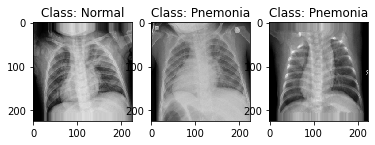

In [ ]:
batch=train_gen[0] # returns the next batch of images and labels 
for i in range (3):
  pyplot.subplot(1,3,i+1)
  img=batch[0][i]   # this is the first image  batch[0][1] would be the next image
  pyplot.imshow(img, cmap='gray', interpolation='none')    
  pyplot.title("Class: {}".format('Normal' if train_gen.classes[i] == 0 else 'Pnemonia'))
pyplot.show()


## DenseNet201



In [ ]:
# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(224,224,3))
#model.summary()

# Congela camadas pré-treinadas
for layer in model.layers:
    layer.trainable = False

# Insere novas camadas no fim da rede para classificação
full_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

full_model.summary()

74842112/74836368 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d (Gl (None, 1920)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1921      
Total params: 18,323,905
Trainable params: 1,921
Non-trainable params: 18,321,984
_________________________________________________________________


##Compilar e treinar o modelo

In [ ]:
#add a earlystopping callback to stop the training if the model is not learning anymore
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

full_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

history = full_model.fit(train_gen, batch_size=64, epochs=10, shuffle=True,
                  validation_data=(val_gen),  callbacks = [callbacks])

Epoch 1/10
67/67 [==============================] - 115s 1s/step - loss: 0.5090 - accuracy: 0.7378 - val_loss: 0.2309 - val_accuracy: 0.9301
Epoch 2/10
67/67 [==============================] - 93s 1s/step - loss: 0.2394 - accuracy: 0.9180 - val_loss: 0.1761 - val_accuracy: 0.9386
Epoch 3/10
67/67 [==============================] - 92s 1s/step - loss: 0.2007 - accuracy: 0.9291 - val_loss: 0.1562 - val_accuracy: 0.9423
Epoch 4/10
67/67 [==============================] - 93s 1s/step - loss: 0.1711 - accuracy: 0.9377 - val_loss: 0.1441 - val_accuracy: 0.9442
Epoch 5/10
67/67 [==============================] - 93s 1s/step - loss: 0.1695 - accuracy: 0.9329 - val_loss: 0.1366 - val_accuracy: 0.9442
Epoch 6/10
67/67 [==============================] - 93s 1s/step - loss: 0.1521 - accuracy: 0.9428 - val_loss: 0.1297 - val_accuracy: 0.9480
Epoch 7/10
67/67 [==============================] - 93s 1s/step - loss: 0.1536 - accuracy: 0.9401 - val_loss: 0.1322 - val_accuracy: 0.9442
Epoch 8/10
67/67 [=

### Plot de Val x Loss

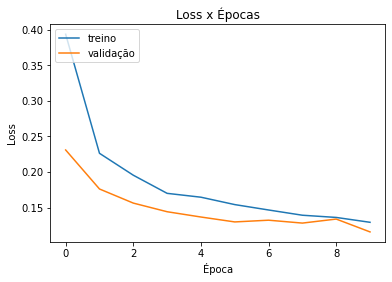

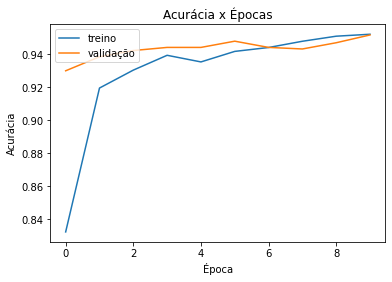

In [ ]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Loss x Épocas')
pyplot.ylabel('Loss')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('Acurácia x Épocas')
pyplot.ylabel('Acurácia')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score

y_pred_train = np.concatenate(full_model.predict_classes(train_gen), axis=0)

y_pred_val = np.concatenate(full_model.predict_classes(val_gen), axis=0)

bas_train = balanced_accuracy_score(train_gen.classes, y_pred_train)
bas_val = balanced_accuracy_score(val_gen.classes, y_pred_val)

scoreTrain = full_model.evaluate(train_gen, verbose = 1)
scoreVal = full_model.evaluate(val_gen, verbose = 1)
print(f'Acurária de treino : {scoreTrain[1]:.4f}')
print(f'Acurária de validação : {scoreVal[1]:.4f}')

print(f'Acurácia balanceada treino : {bas_train:.4f}')
print(f'Acurácia balanceada validação : {bas_val:.4f}')


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


17/17 [==============================] - 11s 660ms/step - loss: 0.1157 - accuracy: 0.9518
Acurária de treino : 0.9529
Acurária de validação : 0.9518
Acurácia balanceada treino : 0.5108
Acurácia balanceada validação : 0.4960


## InceptionV3

In [ ]:
# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(255,255, 3))
#model.summary()

# Congela camadas pré-treinadas
model.trainable = False

# Insere novas camadas no fim da rede para classificação
full_model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(64, activation='tanh', kernel_regularizer = tf.keras.regularizers.l2(0.01), kernel_initializer = "random_normal"),
  tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer = "random_normal")
])

full_model.summary()

87916544/87910968 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                131136    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 21,933,985
Trainable params: 131,201
Non-trainable params: 21,802,784
_________________________________________________________________


##Compilar e treinar o modelo

In [ ]:
#add a earlystopping callback to stop the training if the model is not learning anymore
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

full_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy']) 

history = full_model.fit(train_gen, batch_size=64, epochs=15, shuffle=True,
                  validation_data=(val_gen),  callbacks = [callbacks])

Epoch 1/15
67/67 [==============================] - 100s 1s/step - loss: 2.8113 - accuracy: 0.7634 - val_loss: 0.9142 - val_accuracy: 0.9017
Epoch 2/15
67/67 [==============================] - 88s 1s/step - loss: 0.7269 - accuracy: 0.9094 - val_loss: 0.3933 - val_accuracy: 0.9395
Epoch 3/15
67/67 [==============================] - 87s 1s/step - loss: 0.4004 - accuracy: 0.9115 - val_loss: 0.2822 - val_accuracy: 0.9386
Epoch 4/15
67/67 [==============================] - 87s 1s/step - loss: 0.2964 - accuracy: 0.9232 - val_loss: 0.2461 - val_accuracy: 0.9376
Epoch 5/15
67/67 [==============================] - 87s 1s/step - loss: 0.2698 - accuracy: 0.9229 - val_loss: 0.2095 - val_accuracy: 0.9527
Epoch 6/15
67/67 [==============================] - 87s 1s/step - loss: 0.2466 - accuracy: 0.9311 - val_loss: 0.1942 - val_accuracy: 0.9499
Epoch 7/15
67/67 [==============================] - 87s 1s/step - loss: 0.2146 - accuracy: 0.9426 - val_loss: 0.1938 - val_accuracy: 0.9414
Epoch 8/15
67/67 [=

### Plot de Val x Loss

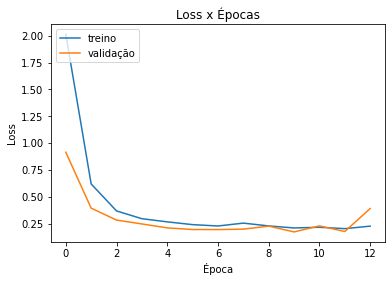

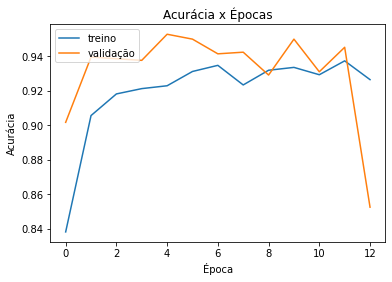

In [ ]:
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('Loss x Épocas')
pyplot.ylabel('Loss')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

pyplot.plot(history.history['accuracy'])
pyplot.plot(history.history['val_accuracy'])
pyplot.title('Acurácia x Épocas')
pyplot.ylabel('Acurácia')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

In [ ]:
scoreTrain = full_model.evaluate(train_gen, verbose = 1)
scoreVal = full_model.evaluate(val_gen, verbose = 1)
print(f'Acurária de treino : {scoreTrain[1]:.4f}')
print(f'Acurária de validação : {scoreVal[1]:.4f}')

17/17 [==============================] - 10s 588ms/step - loss: 0.3893 - accuracy: 0.8526
Acurária de treino : 0.8631
Acurária de validação : 0.8526


In [ ]:
from sklearn.metrics import balanced_accuracy_score

y_pred_train = np.concatenate(full_model.predict_classes(train_gen), axis=0)

y_pred_val = np.concatenate(full_model.predict_classes(val_gen), axis=0)

bas_train = balanced_accuracy_score(train_gen.classes, y_pred_train)
bas_val = balanced_accuracy_score(val_gen.classes, y_pred_val)

print(f'Acurácia balanceada treino : {bas_train:.4f}')
print(f'Acurácia balanceada validação : {bas_val:.4f}')


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Acurácia balanceada treino : 0.4958
Acurácia balanceada validação : 0.4923


## Conjunto de dados com presença positiva da doença

In [ ]:
df_sick = df.loc[df.Label == 'Pnemonia']
df_sick = df_sick.loc[df_sick.Label_1_Virus_category != 'Stress-Smoking']
df_sick = df_sick.loc[df_sick.Label_1_Virus_category != 'unknown'].reset_index(drop=True)

trainVal_sick = df_sick.loc[df_sick.Dataset_type == 'TRAIN']
test_sick = df_sick.loc[df_sick.Dataset_type == 'TEST']

# Shuffle and split test database into 80% train and 20% validation
nData = trainVal_sick.shape[0]
nTrain = int(nData * 0.8)
randomIdx = np.random.permutation(np.arange(nData))
trainIdx = randomIdx[:nTrain]
valIdx = randomIdx[nTrain:]

val_sick = trainVal_sick.copy().drop(trainIdx)
train_sick = trainVal_sick.copy().drop(valIdx)

print("Conjunto de Treino -> ", train_sick.shape)
print("Conjunto de Validação -> ", val_sick.shape)
print("Conjunto de Teste -> ", test_sick.shape)

Conjunto de Treino ->  (3153, 6)
Conjunto de Validação ->  (789, 6)
Conjunto de Teste ->  (390, 6)


## Ocorrência de elementos

In [ ]:
np.random.seed(21100109)

print(train_sick['Label_1_Virus_category'].value_counts()) 

remove_n = train_sick['Label_1_Virus_category'].value_counts()[0] - train_sick['Label_1_Virus_category'].value_counts()[1]
print(remove_n)

drop_indices = np.random.choice(train_sick[train_sick['Label_1_Virus_category'] =='bacteria'].index, remove_n, replace=False)
df_subset = train_sick.loc[drop_indices, :]
train_sick = train_sick.drop(drop_indices)
print(train_sick['Label_1_Virus_category'].value_counts()) 


bacteria    2035
Virus       1118
Name: Label_1_Virus_category, dtype: int64
917
bacteria    1118
Virus       1118
Name: Label_1_Virus_category, dtype: int64


## Data Generator com presença de Pneumonia

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

train_path = '/content/files/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
test_path = '/content/files/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'

pneumonia_train_gen = train_datagen.flow_from_dataframe(dataframe=train_sick,
                                             directory=train_path,
                                             x_col="X_ray_image_name",
                                             y_col="Label_1_Virus_category",
                                             target_size=(255, 255),
                                             batch_size=32,
                                             class_mode='binary',
                                              shuffle=True
                                             )
pneumonia_val_gen = val_datagen.flow_from_dataframe(dataframe=val_sick,
                                             directory=train_path,
                                             x_col="X_ray_image_name",
                                             y_col="Label_1_Virus_category",
                                             target_size=(255, 255),
                                             batch_size=32,
                                             class_mode='binary',
                                              shuffle=True
                                             )
pneumonia_train_gen.class_indices

class_weights = compute_class_weight("balanced", np.unique(pneumonia_train_gen.classes), pneumonia_train_gen.classes)
train_class_weights = dict(enumerate(class_weights))

print(train_class_weights)

Found 2236 validated image filenames belonging to 2 classes.
Found 789 validated image filenames belonging to 2 classes.
{0: 1.0, 1: 1.0}


In [ ]:
pneumonia_train_gen.class_indices

{'Virus': 0, 'bacteria': 1}

## DenseNet201 modelo com doença positiva


In [ ]:
# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
model = tf.keras.applications.DenseNet201(weights='imagenet', include_top=False, input_shape=(255,255, 3))
#model.summary()

# Congela camadas pré-treinadas
for layer in model.layers:
    layer.trainable = False

# Insere novas camadas no fim da rede para classificação
full_model_sick = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(128),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

full_model_sick.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Functional)     (None, 8, 8, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1920)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               245888    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 18,568,001
Trainable params: 246,017
Non-trainable params: 18,321,984
_________________________________________________________________


In [ ]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau

#Adicionando um early stopping e um learning rate reduction
monitor = "val_accuracy"
early_stop=tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)
Learning_rate_reduction=ReduceLROnPlateau(monitor=monitor,patience=2,verbose=1,factor=0.5,min_lr=0.001)
callbacks=[Learning_rate_reduction]

full_model_sick.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_sick = full_model_sick.fit(pneumonia_train_gen, batch_size=128, epochs=15, shuffle=True,
                  class_weight=train_class_weights, validation_data=(pneumonia_val_gen), callbacks=[callbacks])

### Plot de Val x Loss

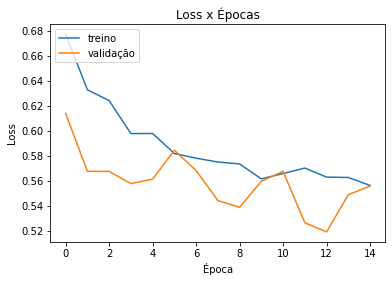

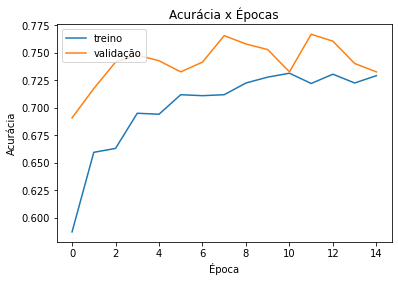

In [ ]:
pyplot.plot(history_sick.history['loss'])
pyplot.plot(history_sick.history['val_loss'])
pyplot.title('Loss x Épocas')
pyplot.ylabel('Loss')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

pyplot.plot(history_sick.history['accuracy'])
pyplot.plot(history_sick.history['val_accuracy'])
pyplot.title('Acurácia x Épocas')
pyplot.ylabel('Acurácia')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

### Acurácia Treino e validação


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

train_eval_result = full_model_sick.evaluate(pneumonia_train_gen) 
validation_eval_result = full_model_sick.evaluate(pneumonia_val_gen)

print(f"Training set accuracy: {train_eval_result[1]}")
print(f"Validation set accuracy: {validation_eval_result[1]}")

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


              precision    recall  f1-score   support

           0       0.50      0.44      0.47      1137
           1       0.50      0.56      0.53      1137

    accuracy                           0.50      2274
   macro avg       0.50      0.50      0.50      2274
weighted avg       0.50      0.50      0.50      2274



### Matriz de confusão Código Auxiliar


In [ ]:
rounded_predictions = full_model_sick.predict_classes(pneumonia_val_gen, batch_size=32, verbose=0)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [ ]:
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

In [ ]:
cm = confusion_matrix(pneumonia_val_gen.classes, rounded_predictions)

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print("Confusion Matrix, without normalization")
    
  print(cm)

  thresh = cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="red" if cm[i, j] > thresh else "black")
    
  plt.tight_layout()
  plt.ylabel("True label")
  plt.xlabel("Predicted label")

Confusion Matrix, without normalization
[[116 165]
 [220 288]]


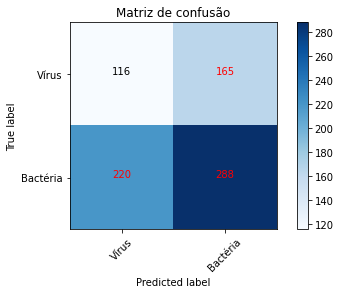

In [ ]:
cm_plot_lables = ['Vírus', 'Bactéria']
plot_confusion_matrix(cm, cm_plot_lables, title="Matriz de confusão")

## Matriz de confusão


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


7/7 [==============================] - 17s 2s/step - loss: 0.5686 - accuracy: 0.7136
Acurária de treino : 0.7376
Acurária de validação : 0.7136
Acurácia balanceada treino : 0.4824
Acurácia balanceada validação : 0.4857


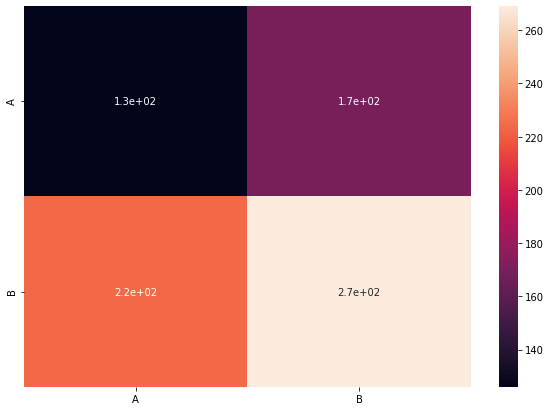

In [ ]:
import seaborn as sn
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, balanced_accuracy_score

y_pred_train = full_model_sick.predict_classes(pneumonia_train_gen)
y_pred_val = full_model_sick.predict_classes(pneumonia_val_gen)

#Testando outra matriz
con_mat = confusion_matrix(pneumonia_val_gen.classes, y_pred_val)

df_cm = pd.DataFrame(con_mat, index = [i for i in "AB"],
                  columns = [i for i in "AB"])

pyplot.figure(figsize = (10,7))
sn.heatmap(df_cm, annot=True)

bas_train = balanced_accuracy_score(pneumonia_train_gen.classes, y_pred_train)
bas_val = balanced_accuracy_score(pneumonia_val_gen.classes, y_pred_val)

scoreTrain = full_model_sick.evaluate(pneumonia_train_gen, verbose = 1)
scoreVal = full_model_sick.evaluate(pneumonia_val_gen, verbose = 1)
print(f'Acurária de treino : {scoreTrain[1]:.4f}')
print(f'Acurária de validação : {scoreVal[1]:.4f}')

print(f'Acurácia balanceada treino : {bas_train:.4f}')
print(f'Acurácia balanceada validação : {bas_val:.4f}')


### DenseNet201 com Fine-tuning

In [ ]:
# Descongela camadas pré-treinadas
for layer in full_model_sick.layers:
    layer.trainable = True

full_model_sick.summary()

In [ ]:
# Compile and train the model
#add a earlystopping callback to stop the training if the model is not learning anymore

full_model_sick.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history_sick_finetuning = full_model_sick.fit(pneumonia_train_gen, batch_size=128, epochs=15, 
                  class_weight=train_class_weights, validation_data=(pneumonia_val_gen), callbacks=[callbacks])

Epoch 1/15
71/71 [==============================] - 94s 1s/step - loss: 0.7198 - accuracy: 0.6120 - val_loss: 1.4140 - val_accuracy: 0.6578
Epoch 2/15
71/71 [==============================] - 79s 1s/step - loss: 0.5964 - accuracy: 0.6949 - val_loss: 0.8548 - val_accuracy: 0.5019
Epoch 3/15
71/71 [==============================] - 79s 1s/step - loss: 0.5813 - accuracy: 0.7049 - val_loss: 0.8375 - val_accuracy: 0.6439

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 4/15
71/71 [==============================] - 79s 1s/step - loss: 0.5558 - accuracy: 0.7323 - val_loss: 1.9941 - val_accuracy: 0.4918
Epoch 5/15
71/71 [==============================] - 79s 1s/step - loss: 0.5754 - accuracy: 0.7203 - val_loss: 1.3567 - val_accuracy: 0.4461

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 6/15
71/71 [==============================] - 79s 1s/step - loss: 0.5303 - accuracy: 0.7502 - val_loss: 0.9174 - val_accuracy: 0.4461
Epoch 7/15
71/71 [============

### Plot de Val x Loss

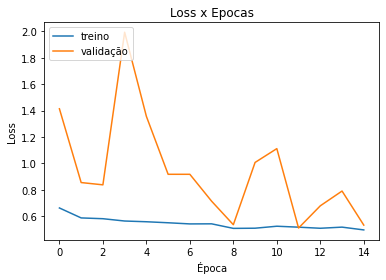

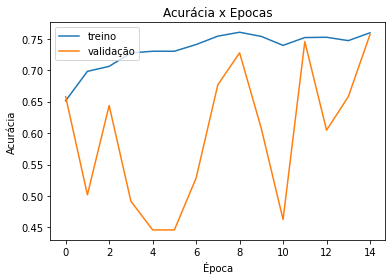

In [ ]:
pyplot.plot(history_sick_finetuning.history['loss'])
pyplot.plot(history_sick_finetuning.history['val_loss'])
pyplot.title('Loss x Epocas')
pyplot.ylabel('Loss')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

pyplot.plot(history_sick_finetuning.history['accuracy'])
pyplot.plot(history_sick_finetuning.history['val_accuracy'])
pyplot.title('Acurácia x Epocas')
pyplot.ylabel('Acurácia')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

## Matriz de confusão



/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion Matrix, without normalization
[[223  53]
 [216  60]]
18/18 [==============================] - 10s 555ms/step - loss: 0.7223 - accuracy: 0.6377
Acurária de treino : 0.6627
Acurária de validação : 0.6377
Acurácia balanceada treino : 0.4965
Acurácia balanceada validação : 0.5109


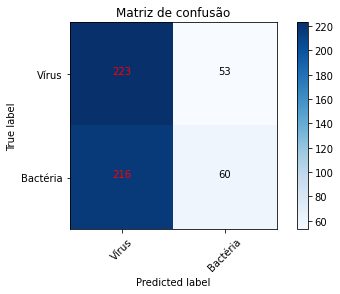

In [ ]:
y_pred_train = full_model_sick.predict_classes(pneumonia_train_gen)
y_pred_val = full_model_sick.predict_classes(pneumonia_val_gen)

bas_train = balanced_accuracy_score(pneumonia_train_gen.classes, y_pred_train)
bas_val = balanced_accuracy_score(pneumonia_val_gen.classes, y_pred_val)

scoreTrain = full_model_sick.evaluate(pneumonia_train_gen, verbose = 1)
scoreVal = full_model_sick.evaluate(pneumonia_val_gen, verbose = 1)
print(f'Acurária de treino : {scoreTrain[1]:.4f}')
print(f'Acurária de validação : {scoreVal[1]:.4f}')

print(f'Acurácia balanceada treino : {bas_train:.4f}')
print(f'Acurácia balanceada validação : {bas_val:.4f}')

## InceptionV3 modelo com doença positiva


In [ ]:
# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(255,255, 3))
#model.summary()

# Congela camadas pré-treinadas
model.trainable = False

# Insere novas camadas no fim da rede para classificação
full_model_sick_v3 = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(64, activation='tanh', kernel_regularizer = tf.keras.regularizers.l2(0.01), kernel_initializer = "random_normal"),
  tf.keras.layers.Dense(1, activation='sigmoid', kernel_initializer = "random_normal")
])

full_model_sick_v3.summary()

87916544/87910968 [==============================] - 1s 0us/step
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 21,933,985
Trainable params: 131,201
Non-trainable params: 21,802,784
_________________________________________________________________


In [ ]:
# full_model_sick_v3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=0.005), metrics=[tf.keras.metrics.AUC(name='auc')])
full_model_sick_v3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=0.005), metrics=['accuracy'])

callbacks = [early_stop, Learning_rate_reduction]

history_sick_v3 = full_model_sick_v3.fit(pneumonia_train_gen, batch_size=128, epochs=30, verbose = 1, shuffle=True,
                  validation_data=(pneumonia_val_gen), class_weight=train_class_weights , callbacks=[callbacks])

Epoch 1/30
71/71 [==============================] - 71s 937ms/step - loss: 2.9902 - accuracy: 0.6024 - val_loss: 1.5685 - val_accuracy: 0.5146
Epoch 2/30
71/71 [==============================] - 64s 909ms/step - loss: 1.2509 - accuracy: 0.6788 - val_loss: 0.9122 - val_accuracy: 0.7199
Epoch 3/30
71/71 [==============================] - 66s 935ms/step - loss: 0.9011 - accuracy: 0.6967 - val_loss: 0.7992 - val_accuracy: 0.7224
Epoch 4/30
71/71 [==============================] - 65s 924ms/step - loss: 0.7946 - accuracy: 0.6961 - val_loss: 0.7264 - val_accuracy: 0.7313
Epoch 5/30
71/71 [==============================] - 65s 921ms/step - loss: 0.7282 - accuracy: 0.7099 - val_loss: 0.7583 - val_accuracy: 0.6591
Epoch 6/30
71/71 [==============================] - 65s 920ms/step - loss: 0.6933 - accuracy: 0.7156 - val_loss: 0.6829 - val_accuracy: 0.7085

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.001.
Epoch 7/30
71/71 [==============================] - 65s 916ms/step - loss: 0.

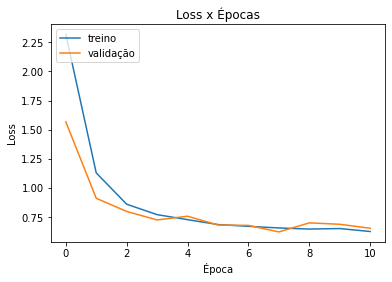

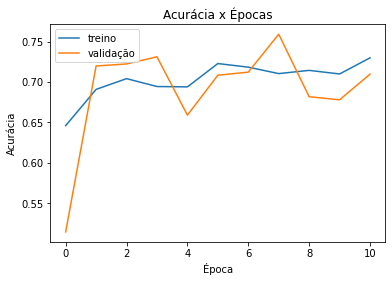

25/25 [==============================] - 17s 671ms/step - loss: 0.6346 - accuracy: 0.7338
Acurária de treino : 0.7287
Acurária de validação : 0.7338


In [ ]:
pyplot.plot(history_sick_v3.history['loss'])
pyplot.plot(history_sick_v3.history['val_loss'])
pyplot.title('Loss x Épocas')
pyplot.ylabel('Loss')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

pyplot.plot(history_sick_v3.history['accuracy'])
pyplot.plot(history_sick_v3.history['val_accuracy'])
pyplot.title('Acurácia x Épocas')
pyplot.ylabel('Acurácia')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

scoreTrain = full_model_sick_v3.evaluate(pneumonia_train_gen, verbose = 1)
scoreVal = full_model_sick_v3.evaluate(pneumonia_val_gen, verbose = 1)
print(f'Acurária de treino : {scoreTrain[1]:.4f}')
print(f'Acurária de validação : {scoreVal[1]:.4f}')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


25/25 [==============================] - 17s 669ms/step - loss: 0.6239 - accuracy: 0.7516
Acurária de treino : 0.7260
Acurária de validação : 0.7516
Acurácia balanceada treino : 0.5044
Acurácia balanceada validação : 0.5081
Confusion Matrix, without normalization
[[103 178]
 [188 320]]


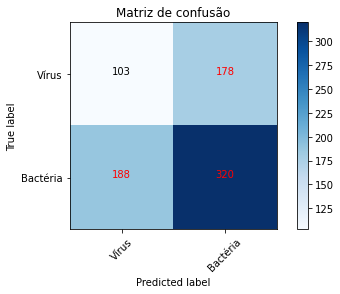

In [ ]:

y_pred_train = full_model_sick_v3.predict_classes(pneumonia_train_gen)
y_pred_val = full_model_sick_v3.predict_classes(pneumonia_val_gen)

bas_train = balanced_accuracy_score(pneumonia_train_gen.classes, y_pred_train)
bas_val = balanced_accuracy_score(pneumonia_val_gen.classes, y_pred_val)

scoreTrain = full_model_sick_v3.evaluate(pneumonia_train_gen, verbose = 1)
scoreVal = full_model_sick_v3.evaluate(pneumonia_val_gen, verbose = 1)
print(f'Acurária de treino : {scoreTrain[1]:.4f}')
print(f'Acurária de validação : {scoreVal[1]:.4f}')

print(f'Acurácia balanceada treino : {bas_train:.4f}')
print(f'Acurácia balanceada validação : {bas_val:.4f}')

rounded_predictions = full_model_sick_v3.predict_classes(pneumonia_val_gen, batch_size=32, verbose=0)
cm = confusion_matrix(pneumonia_val_gen.classes, rounded_predictions)
cm_plot_lables = ['Vírus', 'Bactéria']
plot_confusion_matrix(cm, cm_plot_lables, title="Matriz de confusão")

### InceptionV3 com Fine-tuning

In [ ]:
# Descongela camadas pré-treinadas
full_model_sick_v3.trainable = True

full_model_sick_v3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 6, 6, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                131136    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
Total params: 21,933,985
Trainable params: 21,899,553
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
#full_model_sick_v3.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(lr=0.001, decay=0.005), metrics=[tf.keras.metrics.AUC(name='auc')])
full_model_sick_v3.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), optimizer=tf.keras.optimizers.Adam(lr=1e-5, decay=0.005), metrics=['accuracy'])

history_sick_finetuning_v3 = full_model_sick_v3.fit(pneumonia_train_gen, batch_size=128, epochs=15, verbose = 1, shuffle=True,
                  validation_data=(pneumonia_val_gen), class_weight=train_class_weights , callbacks=[callbacks])

Epoch 1/15
71/71 [==============================] - 81s 1s/step - loss: 0.6698 - accuracy: 0.7077 - val_loss: 0.7674 - val_accuracy: 0.6033
Epoch 2/15
71/71 [==============================] - 74s 1s/step - loss: 0.6353 - accuracy: 0.7412 - val_loss: 0.7106 - val_accuracy: 0.6641
Epoch 3/15
71/71 [==============================] - 74s 1s/step - loss: 0.6338 - accuracy: 0.7446 - val_loss: 0.7037 - val_accuracy: 0.6857
Epoch 4/15
71/71 [==============================] - 74s 1s/step - loss: 0.6088 - accuracy: 0.7481 - val_loss: 0.6934 - val_accuracy: 0.6895
Epoch 5/15
71/71 [==============================] - 74s 1s/step - loss: 0.5946 - accuracy: 0.7580 - val_loss: 0.6880 - val_accuracy: 0.7174
Epoch 6/15
71/71 [==============================] - 74s 1s/step - loss: 0.5895 - accuracy: 0.7681 - val_loss: 0.6542 - val_accuracy: 0.7326
Epoch 7/15
71/71 [==============================] - 73s 1s/step - loss: 0.5689 - accuracy: 0.7782 - val_loss: 0.6377 - val_accuracy: 0.7275
Epoch 8/15
71/71 [==

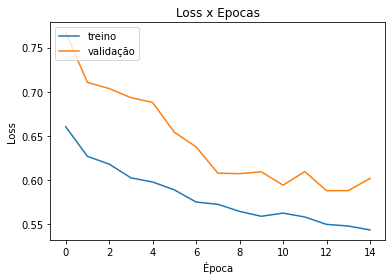

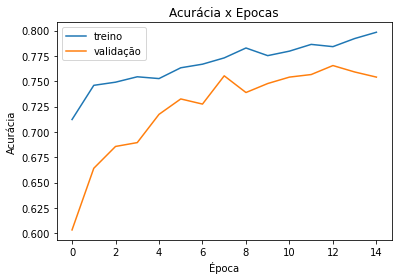

25/25 [==============================] - 17s 663ms/step - loss: 0.5970 - accuracy: 0.7655
Acurária de treino : 0.8020
Acurária de validação : 0.7655


In [ ]:
pyplot.plot(history_sick_finetuning_v3.history['loss'])
pyplot.plot(history_sick_finetuning_v3.history['val_loss'])
pyplot.title('Loss x Epocas')
pyplot.ylabel('Loss')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

pyplot.plot(history_sick_finetuning_v3.history['accuracy'])
pyplot.plot(history_sick_finetuning_v3.history['val_accuracy'])
pyplot.title('Acurácia x Epocas')
pyplot.ylabel('Acurácia')
pyplot.xlabel('Época')
pyplot.legend(['treino', 'validação'], loc='upper left')
pyplot.show()

scoreTrain = full_model_sick_v3.evaluate(pneumonia_train_gen, verbose = 1)
scoreVal = full_model_sick_v3.evaluate(pneumonia_val_gen, verbose = 1)
print(f'Acurária de treino : {scoreTrain[1]:.4f}')
print(f'Acurária de validação : {scoreVal[1]:.4f}')

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


25/25 [==============================] - 17s 662ms/step - loss: 0.5968 - accuracy: 0.7706
Acurária de treino : 0.8046
Acurária de validação : 0.7706
Acurácia balanceada treino : 0.4938
Acurácia balanceada validação : 0.4899
Confusion Matrix, without normalization
[[122 159]
 [219 289]]


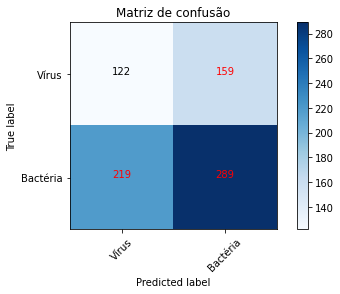

In [ ]:
y_pred_train = full_model_sick_v3.predict_classes(pneumonia_train_gen)
y_pred_val = full_model_sick_v3.predict_classes(pneumonia_val_gen)

bas_train = balanced_accuracy_score(pneumonia_train_gen.classes, y_pred_train)
bas_val = balanced_accuracy_score(pneumonia_val_gen.classes, y_pred_val)

scoreTrain = full_model_sick_v3.evaluate(pneumonia_train_gen, verbose = 1)
scoreVal = full_model_sick_v3.evaluate(pneumonia_val_gen, verbose = 1)
print(f'Acurária de treino : {scoreTrain[1]:.4f}')
print(f'Acurária de validação : {scoreVal[1]:.4f}')

print(f'Acurácia balanceada treino : {bas_train:.4f}')
print(f'Acurácia balanceada validação : {bas_val:.4f}')


rounded_predictions = full_model_sick_v3.predict_classes(pneumonia_val_gen, batch_size=32, verbose=0)
cm = confusion_matrix(pneumonia_val_gen.classes, rounded_predictions)
cm_plot_lables = ['Vírus', 'Bactéria']
plot_confusion_matrix(cm, cm_plot_lables, title="Matriz de confusão")

## RESULTADO BASE TESTE

In [ ]:

pneumonia_test_gen = train_datagen.flow_from_dataframe(dataframe=test_sick,
                                             directory=test_path,
                                             x_col="X_ray_image_name",
                                             y_col="Label_1_Virus_category",
                                             target_size=(255, 255),
                                             batch_size=32,
                                             class_mode='binary',
                                              shuffle=True
                                             )

pneumonia_test_gen.class_indices
scoreTest = full_model_sick_v3.evaluate(pneumonia_test_gen, verbose = 1)
print(f'Acurária de teste : {scoreTest[1]:.4f}')

y_pred_test = full_model_sick_v3.predict_classes(pneumonia_test_gen, verbose=0)
bas_test = balanced_accuracy_score(pneumonia_test_gen.labels, y_pred_test)
print(f'Acurácia balanceada teste : {bas_test:.4f}')


Found 390 validated image filenames belonging to 2 classes.
13/13 [==============================] - 8s 583ms/step - loss: 0.4081 - accuracy: 0.8821
Acurária de teste : 0.8821


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Acurácia balanceada teste : 0.5684


## Matriz confusão base de Teste

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Confusion Matrix, without normalization
[[ 57  91]
 [ 93 149]]


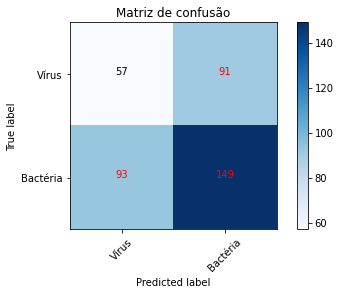

In [ ]:
rounded_predictions = full_model_sick_v3.predict_classes(pneumonia_test_gen, batch_size=32, verbose=0)
cm = confusion_matrix(pneumonia_test_gen.classes, rounded_predictions)
cm_plot_lables = ['Vírus', 'Bactéria']
plot_confusion_matrix(cm, cm_plot_lables, title="Matriz de confusão")